# Lab4 - Custom scheduler

### Expanding Platform with one more cpu - CPU4

Validating System platform: MTL...
System platform is valid!


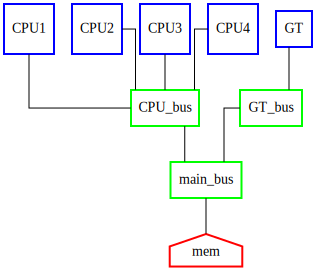

In [1]:
from labs.lab1_creating_platform import create_platform_step_by_step
from asap.ips import Port, Driver, ExecutingUnit, IP

sys_platform = create_platform_step_by_step()
a_clk = sys_platform.get_clock('a_clk')
cpu_p = Port('cpu_p4')
cpu_dr = Driver('dr4', a_clk)
cpu_ex = ExecutingUnit('ex_u4', a_clk)
cpu = IP('CPU4', a_clk, [cpu_ex], [cpu_dr], [cpu_p])
cpu.connect_driver(cpu_dr, cpu_p)
sys_platform.add_ip(cpu)
cpu_bus = sys_platform.get_bus('CPU_bus')
sys_platform.connect_to_bus(cpu_p, cpu_bus)
sys_platform


### Expanding workload

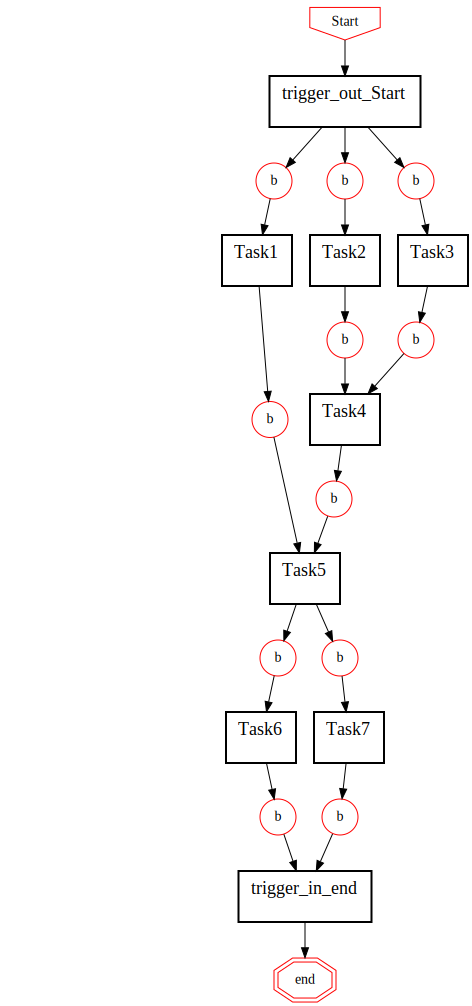

In [2]:
from labs.lab2_creating_workload import create_workload
from asap.workload import Task, Connection, TYPES

workload = create_workload()
task5 = workload.get_task('Task5')
end = workload.get_task('end')
workload.disconnect_tasks(task5, end)

task6 = Task('Task6', TYPES.PROC, processing_cycles=1200)
task7 = Task('Task7', TYPES.PROC, processing_cycles=1600)
workload.add_tasks([task6, task7])
workload.connect_tasks('con12', task5, task6)
workload.connect_tasks('con13', task5, task7)
workload.connect_tasks('con14', task6, end)
workload.connect_tasks('con15', task7, end)
workload

### Adding new attribute 'MAP_TYPE' to tasks:
####     - Task4 and Task6 MAP_TYPE = GT
####     - rest of tasks MAP_TYPE = CPU

In [3]:
# Every model in SpeedSim is a dynamic model, any attribute can be attached
MAP_TYPE = 'MAP_TYPE'
task_to_map_type = {'Task1': 'CPU', 'Task2': 'CPU', 'Task3': 'CPU', 'Task5': 'CPU', 'Task7': 'CPU','Task4': 'GT', 'Task6': 'GT'}

for task in workload.tasks:
    task.attach_attribute(MAP_TYPE, task_to_map_type.get(task.name, 'CPU'))


### Custom scheduler
##### Tasks with attribute MAP_TYPE = 'CPU' should be scheduled to one of the CPUs
##### Tasks with attribute MAP_TYPE = 'GT' should be scheduled to GT

In [4]:
from asap.schedulers import SystemScheduler
from asap.mapping import MappingEntity

class CustomScheduler(SystemScheduler):
    def __init__(self, system_mgr, properties=None, platform_scheduler=None):
        super().__init__(system_mgr, properties, platform_scheduler)
        self.cpus = [ip for ip in self._system_mgr.sys_platform.ips if ip.name.startswith('CPU')]
        self.gts = [ip for ip in self._system_mgr.sys_platform.ips if ip.name.startswith('GT')]
    
    def get_task_mappings(self, task):
        map_type = task.get_attribute(MAP_TYPE) 
        if map_type is None:
            return []
        if map_type == 'CPU':
            return [MappingEntity(task, cpu) for cpu in self.cpus]
        if map_type == 'GT':
            return [MappingEntity(task, cpu) for cpu in self.gts]
        return []

#### Running with custom scheduler

In [5]:
from speedsim import SpeedSim

speedsim = SpeedSim(sys_platform, workload, None)
speedsim.set_system_scheduler(CustomScheduler)
res = speedsim.simulate()
res

,START,FINISH,TRANSITION,RESOURCE,RESOURCE_IDX,DURATION
0,0.0,10.0,Task1,CPU1/ex_u1,0,10.0
1,0.0,10.0,Task2,CPU2/ex_u2,0,10.0
2,0.0,10.0,Task3,CPU3/ex_u3,0,10.0
3,10.0,32.0,Task4,GT/ex_ug,0,22.0
4,32.0,40.0,Task5,CPU1/ex_u1,0,8.0
5,40.0,52.0,Task6,GT/ex_ug,0,12.0
6,40.0,56.0,Task7,CPU1/ex_u1,0,16.0
